# Alignment and RNA velocity analysis of single-cell RNA-seq data.

The kallisto, bustools and kb-python programs are free, open-source software tools for performing this analysis that together can produce gene expression quantification from raw sequencing reads. In this tutorial, we will perform pre-processing and RNA velocity analysis of human week 10 fetal forebrain dataset ([SRR6470906](https://www.ncbi.nlm.nih.gov/sra/?term=SRR6470906)) from [La Manno et al., 2018](https://www.nature.com/articles/s41586-018-0414-6) using the kallisto | bustools workflow.

We made an improvement in integrating the kallisto, bustools and kb-python program in OmicVerse:

* **More user-friendly function implementation**： we automated their encapsulation into the ```omicverse.alignment``` class.

If you found this tutorial helpful, please cite kb-python and OmicVerse:

* Sullivan, D.K., Min, K.H.(., Hjörleifsson, K.E. et al. kallisto, bustools and kb-python for quantifying bulk, single-cell and single-nucleus RNA-seq. Nature Protocol (2025).
https://doi.org/10.1038/s41596-024-01057-0

* Melsted, P., Booeshaghi, A.S., Liu, L. et al. Modular, efficient and constant-memory single-cell RNA-seq preprocessing. Nature Biotechnology (2021). https://doi.org/10.1038/s41587-021-00870-2

In [1]:
import omicverse as ov
import scanpy as sc
import pandas as pd
import numpy as np
ov.plot_set(font_path='Arial')

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting GPU devices…
✅ NVIDIA CUDA GPUs detected: 8
    • [CUDA 0] NVIDIA GeForce RTX 4090 D
      Memory: 23.6 GB | Compute: 8.9
    • [CUDA 1] NVIDIA GeForce RTX 4090 D
      Memory: 23.6 GB | Compute: 8.9
    • [CUDA 2] NVIDIA GeForce RTX 4090 D
      Memory: 23.6 GB | Compute: 8.9
    • [CUDA 3] NVIDIA GeForce RTX 4090 D
      Memory: 23.6 GB | Compute: 8.9
    • [CUDA 4] NVIDIA GeForce RTX 4090 D
      Memory: 23.6 GB | Compute: 8.9
    • [CUDA 5] NVIDIA GeForce RTX 4090 D
      Memory: 23.6 GB | Compute: 8.9
    • [CUDA 6] NVIDIA GeForce RTX 4090 D
      Memory: 23.6 GB | Compute: 8.9
    • [CUDA 7] NVIDIA GeForce RTX 4090 D
      Memory: 23.6 GB | Compute: 8.9

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__ 

## Download human reference files and build the index
We build a human cDNA and intron index from the human genome and annotations provided by Ensembl.

In [ ]:
%%time
!wget -P velocity ftp://ftp.ensembl.org/pub/release-108/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz
!wget -P velocity ftp://ftp.ensembl.org/pub/release-108/gtf/homo_sapiens/Homo_sapiens.GRCh38.108.gtf.gz

Here we build a human RNA velocity index, and you can see this [notebook](https://www.kallistobus.tools/tutorials/kb_velocity_index/python/kb_velocity_index/) for more details about how to RNA velocity indices. 

In [2]:
result=ov.alignment.ref(
  fasta_paths='velocity/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz', #input
  gtf_paths='velocity/Homo_sapiens.GRCh38.108.gtf.gz', #input
  index_path='velocity/index.idx',  #output
  t2g_path='velocity/t2g.txt',  #output
  cdna_path='velocity/cdna.fa',  #output
  f2='velocity/intron.fa',  #output
  c1='velocity/cdna_t2c.txt',  #output
  c2='velocity/intron_t2c.txt',  #output
  workflow='lamanno',
  threads=8
)
print(result.keys())

🚀 Starting ref workflow: lamanno
    Executing lamanno workflow
✓ ref workflow completed!
dict_keys(['cdna_fasta', 'cdna_t2c', 'intron_fasta', 'intron_t2c', 't2g', 'index', 'workflow', 'technology', 'parameters'])


## Generate RNA velocity count matrices

The following command will generate an RNA count matrix of cells (rows) by genes (columns) in H5AD format, which is a binary format used to store Anndata objects. Notice we are providing the index and transcript-to-gene mapping we downloaded in the previous step to the ```-i``` and ```-g``` arguments respectively, as well as the transcripts-to-capture lists to the ```-c1``` and ```-c2``` arguments. Also, these reads were generated with the 10x Genomics Chromium Single Cell v2 Chemistry, hence the ```-x 10xv2``` argument. 

In [ ]:
!wget -P velocity https://caltech.box.com/shared/static/nvzqphhklk1yx938l6omursw7sr68y43.gz -O SRR6470906_S1_L001_R1_001.fastq.gz
!wget -P velocity https://caltech.box.com/shared/static/63fh2xa5t82x7s74rqa0e2u2ur59y5ox.gz -O SRR6470906_S1_L001_R2_001.fastq.gz
!wget -P velocity https://caltech.box.com/shared/static/zqi3durukillaw1pbns1kd1lowyfg5qk.gz -O SRR6470906_S1_L002_R1_001.fastq.gz
!wget -P velocity https://caltech.box.com/shared/static/i56qojfz41ns1kw9z86sla0vawsch96t.gz -O SRR6470906_S1_L002_R2_001.fastq.gz

In [3]:
result=ov.alignment.count(
    fastq_paths=['velocity/SRR6470906_S1_L001_R1_001.fastq.gz', #input
                 'velocity/SRR6470906_S1_L001_R2_001.fastq.gz', #input
                 'velocity/SRR6470906_S1_L002_R1_001.fastq.gz', #input
                 'velocity/SRR6470906_S1_L002_R2_001.fastq.gz'],#input
    output_path='velocity/SRR6470906', #input
    index_path='velocity/index.idx', #input
    t2g_path='velocity/t2g.txt', #input
    c1='velocity/cdna_t2c.txt', #input
    c2='velocity/intron_t2c.txt', #input
    technology='10xv2',
    workflow='lamanno', 
    h5ad=True,  
    filter_barcodes=True,  # 
)
print(result.keys())

🚀 Starting count workflow: lamanno
    Technology: 10xv2
    Output directory: velocity/SRR6470906
    Executing lamanno workflow
✓ count workflow completed!
dict_keys(['workflow', 'technology', 'output_path', 'parameters', 'unfiltered', 'filtered', 'stats'])


## Analysis

In this part of the tutorial, we will load the RNA count matrix generated by kb count into Python and analyse them using the omicverse pipeline.

You can find detailed information about these codes in this [website](https://omicverse.readthedocs.io/en/latest/Tutorials-velo/t_velo/).


In [4]:
adata = sc.read_h5ad("velocity/SRR6470906/counts_filtered/adata.h5ad")
adata.layers['spliced'] = adata.layers['mature']
adata.layers['unspliced'] = adata.layers['nascent']

In [5]:
velo_obj=ov.single.Velo(adata)
velo_obj.filter_genes(min_shared_counts=20)
velo_obj.preprocess()

In Velo module, you should keep all genes' expression not normalized.
Filtered out 53587 genes that are detected 20 counts (shared).
|-----> Running monocle preprocessing pipeline...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
2 input query terms found dup hits:	[('ENSG00000227110', 2), ('ENSG00000243620', 2)]
8 input query terms found no hit:	['ENSG00000259407', 'ENSG00000259972', 'ENSG00000261386', 'ENSG00000291120', 'ENSG00000233937', 'ENS


|-----> Subsetting adata object and removing Nan columns from adata when converting gene names.
|-----------> filtered out 1151 outlier cells
|-----------> filtered out 1502 outlier genes
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> computing cell phase...
|-----> [Cell Phase Estimation] completed [38.0845s]
|-----> [Cell Cycle Scores Estimation] completed [0.4048s]
|-----> [Preprocessor-monocle] completed [37.7844s]
🖥️ Using Scanpy CPU to calculate neighbors...

🔍 K-Nearest Neighbors Graph Construction:
   Mode: cpu
   Neighbors: 30
   Method: umap
   Metric: euclidean
   Representation: X_pca
   PCs used: 30
computing neighbors
   🔍 Computing neighbor distances...
   🔍 Computing connectivity matrix...
   💡 Using UMAP-style connectivity
   ✓ Graph is fully connected

✅ KNN Graph Construction Completed Successfully!
   ✓ Processed: 4,331 cells with 30 neighbors each
   ✓ Results added to AnnData object:
     • 'neighbors': Neighbors metadata

In [6]:
velo_obj.moments(backend='scvelo')
velo_obj.dynamics(backend='scvelo',n_jobs=8)
velo_obj.cal_velocity(method='scvelo')

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/384 cores)


  0%|          | 0/2100 [00:00<?, ?gene/s]

    finished (0:01:21) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities


/opt/miniforge/envs/omicverse_working/lib/python3.11/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [7]:
velo_obj.velocity_graph(
    vkey='velocity_S',
    xkey='Ms',
    n_jobs=8,
)

computing velocity graph (using 8/384 cores)


  0%|          | 0/4331 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_S_graph', sparse matrix with cosine correlations (adata.uns)


In [8]:
ov.pp.neighbors(adata, n_neighbors=15, 
               use_rep='X_pca')
ov.pp.umap(adata)
ov.pp.leiden(adata,resolution=0.2)

🖥️ Using Scanpy CPU to calculate neighbors...

🔍 K-Nearest Neighbors Graph Construction:
   Mode: cpu
   Neighbors: 15
   Method: umap
   Metric: euclidean
   Representation: X_pca
computing neighbors
   🔍 Computing neighbor distances...
   🔍 Computing connectivity matrix...
   💡 Using UMAP-style connectivity
   ✓ Graph is fully connected

✅ KNN Graph Construction Completed Successfully!
   ✓ Processed: 4,331 cells with 15 neighbors each
   ✓ Results added to AnnData object:
     • 'neighbors': Neighbors metadata (adata.uns)
     • 'distances': Distance matrix (adata.obsp)
     • 'connectivities': Connectivity matrix (adata.obsp)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
🔍 [2025-10-23 13:30:57] Running UMAP in 'cpu' mode...
🖥️ Using Scanpy CPU UMAP...

🔍 UMAP Dimensionality Reduction:
   Mode: cpu
   Method: umap
   Components: 2
   Min distance: 0.5
{'n_ne

In [9]:
velo_obj.velocity_embedding(
    basis='umap',
    vkey='velocity_S',
)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_S_umap', embedded velocity vectors (adata.obsm)


Text(0.5, 1.0, 'Velocity: Dynamo')

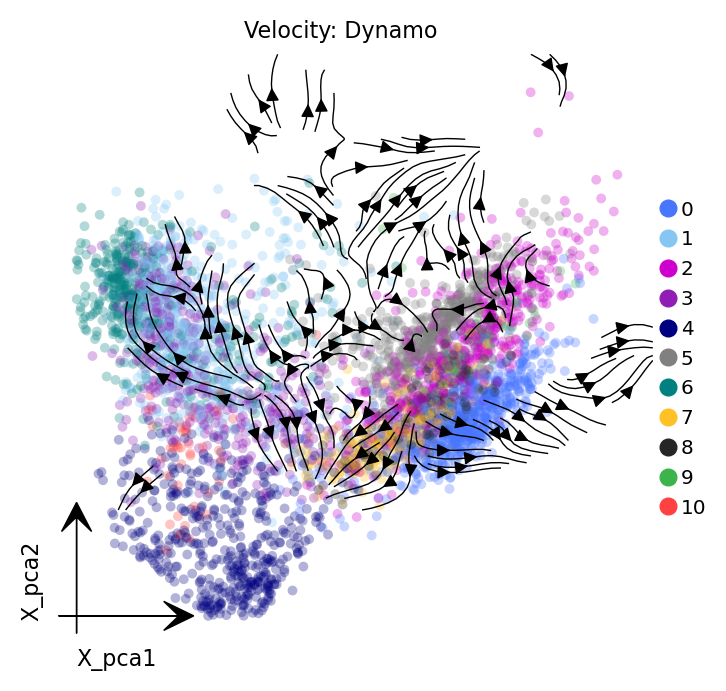

In [10]:
fig = ov.plt.figure(figsize=(4, 4))
ax = ov.plt.subplot(1, 1, 1)
ov.pl.embedding(
    adata,
    basis='X_pca',
    color='leiden',
    ax=ax,
    show=False,
    size=50,
    alpha=0.3
)
ov.pl.add_streamplot(
    adata,
    basis='X_umap',
    velocity_key='velocity_S_umap',
    ax=ax,
)
ov.plt.title('Velocity: Dynamo')